# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

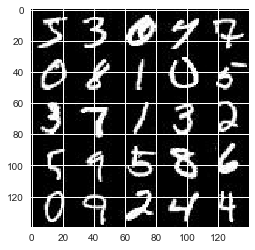

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

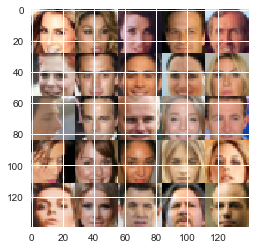

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/martbert/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    inputs_z = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :param alpha: float value between 0 and 1 to control the "leakiness" of the relu
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input image is 28x28x(1 or 3)
        # First pass: add some depth
        c1 = tf.layers.conv2d(images, 64, 5, strides=1, padding='same')
        relu1 = tf.maximum(alpha * c1, c1)
        
        # Second pass: transform to 14x14x128
        c2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(c2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # Second pass transforms to 7x7x256
        c3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(c3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # Flatten the final activated convolution
        cflat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(cflat, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [23]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        # Pass the input z to a fully connected layer first
        fc1 = tf.layers.dense(z, 7*7*256)
        
        # Reshape to pass to the convolutions
        # Batch normalize and apply leaky relu
        c1 = tf.reshape(fc1, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(c1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        
        # Image will be 14x14x128
        c2 = tf.layers.conv2d_transpose(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(c2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # Image will be 28x28x64
        c3 = tf.layers.conv2d_transpose(relu2, 64, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(c3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # Output layer (multiply by 0.5 to scale to the correct range)
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same')
        output = tf.tanh(logits)
    
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # Generate image
    g_output = generator(input_z, out_channel_dim, is_train=True)
    
    # Discrimate on both real and fake image
    d_output_real, d_logits_real = discriminator(input_real, reuse=False)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)
    
    # Loss for real image
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, 
        labels=tf.ones_like(d_output_real)
    ))
    
    # Loss for fake image
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, 
        labels=tf.zeros_like(d_output_fake)
    ))
    
    # Total discriminator loss
    d_loss = d_loss_real + d_loss_fake
    
    # Geneartor loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, 
        labels=tf.ones_like(d_output_fake)
    ))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [17]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get the trainables
    trainables = tf.trainable_variables()
    
    # Find variables associated with both the discriminator and the generator via the scope
    dv = [v for v in trainables if v.name.startswith('discriminator')]
    gv = [v for v in trainables if v.name.startswith('generator')]
    
    # Optimize using adam
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_op = tf.train.AdamOptimizer(
            learning_rate,
            beta1=beta1
        ).minimize(
            d_loss,
            var_list=dv
        )
        
        g_train_op = tf.train.AdamOptimizer(
            learning_rate,
            beta1=beta1
        ).minimize(
            g_loss,
            var_list=gv
        )
    return d_train_op, g_train_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [28]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Determine the number of channels for the image
    if data_image_mode == 'RGB':
        image_channels = 3
    elif data_image_mode == 'L':
        image_channels = 1
    else:
        raise "data_image_mode has to be either RGB or L"
    
    # Width and height
    image_width, image_height = data_shape[1], data_shape[2]
    
    # Inputs placeholders
    input_real, input_z, lrate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Losses
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    # Optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, lrate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1 
                
                # Normalize between -1 and 1
                batch_images *= 2
                
                # Random noise for the generator (batch_size, z_dim)
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run the optimizers
                _ = sess.run(d_opt, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z,
                    lrate: learning_rate
                })
                
                _ = sess.run(g_opt, feed_dict={
                    input_real: batch_images,
                    input_z: batch_z,
                    lrate: learning_rate
                })
                
                # Print the losses
                if steps % 5 == 0:
                    d_loss_train = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    g_loss_train = g_loss.eval({input_z: batch_z})
                    
                    msg = "Epoch {}/{}; d_loss: {:.4f}; g_loss: {:.4f}".format(
                        epoch_i+1, epoch_count, d_loss_train, g_loss_train
                    )
                    print(msg)
                    
                # View samples
                if steps % 100 == 0:
                    # The generator output
                    show_generator_output(sess, 36, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2; d_loss: 1.7340; g_loss: 0.2777
Epoch 1/2; d_loss: 2.9799; g_loss: 0.0733
Epoch 1/2; d_loss: 0.8686; g_loss: 2.0054
Epoch 1/2; d_loss: 1.1395; g_loss: 0.6292
Epoch 1/2; d_loss: 3.7750; g_loss: 0.0285
Epoch 1/2; d_loss: 0.6872; g_loss: 2.6833
Epoch 1/2; d_loss: 2.8894; g_loss: 0.0806
Epoch 1/2; d_loss: 1.3956; g_loss: 0.6238
Epoch 1/2; d_loss: 1.3921; g_loss: 0.7480
Epoch 1/2; d_loss: 2.3604; g_loss: 0.1326
Epoch 1/2; d_loss: 1.2101; g_loss: 0.5645
Epoch 1/2; d_loss: 2.2751; g_loss: 0.1754
Epoch 1/2; d_loss: 1.7571; g_loss: 0.2834
Epoch 1/2; d_loss: 1.4652; g_loss: 1.2098
Epoch 1/2; d_loss: 1.8684; g_loss: 0.2440
Epoch 1/2; d_loss: 1.1110; g_loss: 0.9973
Epoch 1/2; d_loss: 1.6965; g_loss: 0.2997
Epoch 1/2; d_loss: 2.4825; g_loss: 0.1203
Epoch 1/2; d_loss: 1.8770; g_loss: 0.2480
Epoch 1/2; d_loss: 1.0756; g_loss: 0.7394


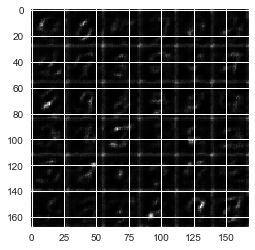

Epoch 1/2; d_loss: 1.9344; g_loss: 0.7408
Epoch 1/2; d_loss: 2.2182; g_loss: 0.1540
Epoch 1/2; d_loss: 1.3857; g_loss: 0.6621
Epoch 1/2; d_loss: 1.1580; g_loss: 0.8281
Epoch 1/2; d_loss: 1.5605; g_loss: 0.8545
Epoch 1/2; d_loss: 1.3360; g_loss: 0.5826
Epoch 1/2; d_loss: 1.8337; g_loss: 0.2112
Epoch 1/2; d_loss: 1.2846; g_loss: 0.6037
Epoch 1/2; d_loss: 1.0449; g_loss: 1.0721
Epoch 1/2; d_loss: 1.2894; g_loss: 1.6114
Epoch 1/2; d_loss: 1.3927; g_loss: 0.3526
Epoch 1/2; d_loss: 1.4018; g_loss: 0.3786
Epoch 1/2; d_loss: 0.9027; g_loss: 0.8756
Epoch 1/2; d_loss: 1.1117; g_loss: 0.6859
Epoch 1/2; d_loss: 1.2614; g_loss: 2.2037
Epoch 1/2; d_loss: 1.6885; g_loss: 0.2643
Epoch 1/2; d_loss: 1.4407; g_loss: 0.3665
Epoch 1/2; d_loss: 1.0323; g_loss: 0.7300
Epoch 1/2; d_loss: 0.9405; g_loss: 0.8085
Epoch 1/2; d_loss: 1.9348; g_loss: 0.1861


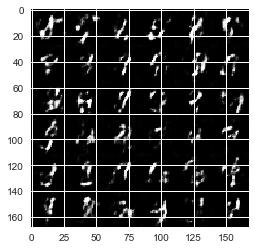

Epoch 1/2; d_loss: 1.3524; g_loss: 0.4246
Epoch 1/2; d_loss: 1.2397; g_loss: 0.6472
Epoch 1/2; d_loss: 1.4569; g_loss: 1.9524
Epoch 1/2; d_loss: 0.9129; g_loss: 0.8272
Epoch 1/2; d_loss: 1.2816; g_loss: 0.4178
Epoch 1/2; d_loss: 0.9939; g_loss: 0.6649
Epoch 1/2; d_loss: 1.4114; g_loss: 0.3784
Epoch 1/2; d_loss: 1.0663; g_loss: 0.5846
Epoch 1/2; d_loss: 0.6464; g_loss: 1.1285
Epoch 1/2; d_loss: 1.8141; g_loss: 0.2775
Epoch 1/2; d_loss: 0.8656; g_loss: 0.8385
Epoch 1/2; d_loss: 0.7094; g_loss: 1.1027
Epoch 1/2; d_loss: 1.0278; g_loss: 0.7766
Epoch 1/2; d_loss: 0.9271; g_loss: 0.7647
Epoch 1/2; d_loss: 1.8127; g_loss: 0.2269
Epoch 1/2; d_loss: 1.1879; g_loss: 0.5158
Epoch 1/2; d_loss: 1.1018; g_loss: 0.6368
Epoch 1/2; d_loss: 1.0452; g_loss: 0.8277
Epoch 1/2; d_loss: 1.6303; g_loss: 0.3195
Epoch 1/2; d_loss: 1.9731; g_loss: 0.2350


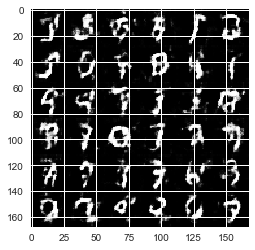

Epoch 1/2; d_loss: 2.3465; g_loss: 0.1233
Epoch 1/2; d_loss: 1.2560; g_loss: 0.5356
Epoch 1/2; d_loss: 0.8347; g_loss: 0.8341
Epoch 1/2; d_loss: 0.9351; g_loss: 0.9611
Epoch 1/2; d_loss: 1.9105; g_loss: 0.2179
Epoch 1/2; d_loss: 1.0953; g_loss: 0.8550
Epoch 1/2; d_loss: 0.9048; g_loss: 0.8165
Epoch 1/2; d_loss: 0.8497; g_loss: 1.5490
Epoch 1/2; d_loss: 0.6158; g_loss: 1.4320
Epoch 1/2; d_loss: 1.4929; g_loss: 0.4157
Epoch 1/2; d_loss: 1.2399; g_loss: 0.4476
Epoch 1/2; d_loss: 0.6236; g_loss: 2.0853
Epoch 1/2; d_loss: 1.5972; g_loss: 0.3343
Epoch 1/2; d_loss: 1.2519; g_loss: 0.4561
Epoch 1/2; d_loss: 0.9767; g_loss: 1.9867
Epoch 1/2; d_loss: 1.0167; g_loss: 0.7467
Epoch 1/2; d_loss: 0.7694; g_loss: 1.2992
Epoch 1/2; d_loss: 1.5531; g_loss: 0.3306
Epoch 1/2; d_loss: 0.9510; g_loss: 0.7249
Epoch 1/2; d_loss: 2.1961; g_loss: 0.1637


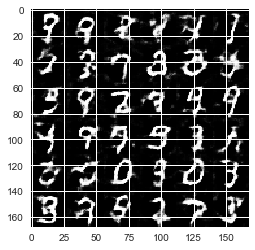

Epoch 1/2; d_loss: 1.5371; g_loss: 0.3739
Epoch 1/2; d_loss: 1.8542; g_loss: 0.2450
Epoch 1/2; d_loss: 1.2765; g_loss: 0.6204
Epoch 1/2; d_loss: 0.9466; g_loss: 0.7646
Epoch 1/2; d_loss: 1.1173; g_loss: 0.5889
Epoch 1/2; d_loss: 1.1605; g_loss: 0.6115
Epoch 1/2; d_loss: 1.3281; g_loss: 0.4835
Epoch 1/2; d_loss: 1.7592; g_loss: 0.3040
Epoch 1/2; d_loss: 1.1171; g_loss: 1.6794
Epoch 1/2; d_loss: 1.3824; g_loss: 0.4364
Epoch 1/2; d_loss: 1.7200; g_loss: 0.2874
Epoch 1/2; d_loss: 1.2255; g_loss: 0.5915
Epoch 1/2; d_loss: 0.8791; g_loss: 0.8615
Epoch 1/2; d_loss: 0.9497; g_loss: 0.7230
Epoch 1/2; d_loss: 1.0376; g_loss: 0.6002
Epoch 1/2; d_loss: 1.4219; g_loss: 0.3818
Epoch 1/2; d_loss: 1.3216; g_loss: 0.4401
Epoch 1/2; d_loss: 1.6634; g_loss: 0.3134
Epoch 1/2; d_loss: 3.9548; g_loss: 5.3163
Epoch 1/2; d_loss: 1.4913; g_loss: 0.3841


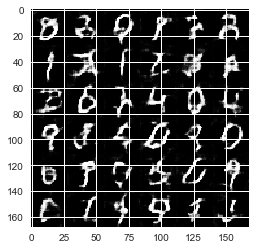

Epoch 1/2; d_loss: 0.7886; g_loss: 1.3726
Epoch 1/2; d_loss: 1.0977; g_loss: 1.2544
Epoch 1/2; d_loss: 0.9951; g_loss: 0.6689
Epoch 1/2; d_loss: 1.5902; g_loss: 0.3314
Epoch 1/2; d_loss: 1.4319; g_loss: 0.3951
Epoch 1/2; d_loss: 1.0366; g_loss: 0.7419
Epoch 1/2; d_loss: 0.8065; g_loss: 1.1607
Epoch 1/2; d_loss: 0.7777; g_loss: 0.9670
Epoch 1/2; d_loss: 2.0521; g_loss: 0.1887
Epoch 1/2; d_loss: 0.7083; g_loss: 1.1627
Epoch 1/2; d_loss: 1.1562; g_loss: 0.5663
Epoch 1/2; d_loss: 0.9253; g_loss: 1.2726
Epoch 1/2; d_loss: 1.5860; g_loss: 2.9443
Epoch 1/2; d_loss: 1.9895; g_loss: 0.1846
Epoch 1/2; d_loss: 1.1919; g_loss: 0.7353
Epoch 1/2; d_loss: 1.0162; g_loss: 0.8837
Epoch 1/2; d_loss: 1.1324; g_loss: 0.6903
Epoch 1/2; d_loss: 0.8342; g_loss: 0.9310
Epoch 1/2; d_loss: 1.4453; g_loss: 0.3675
Epoch 1/2; d_loss: 1.8505; g_loss: 0.2254


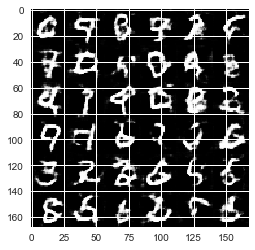

Epoch 1/2; d_loss: 0.7364; g_loss: 1.6993
Epoch 1/2; d_loss: 1.3585; g_loss: 0.4580
Epoch 1/2; d_loss: 0.8907; g_loss: 0.9841
Epoch 1/2; d_loss: 1.1867; g_loss: 0.5343
Epoch 1/2; d_loss: 2.2694; g_loss: 0.1423
Epoch 1/2; d_loss: 2.0951; g_loss: 2.2357
Epoch 1/2; d_loss: 1.4096; g_loss: 1.2325
Epoch 1/2; d_loss: 1.1808; g_loss: 0.7035
Epoch 1/2; d_loss: 1.1911; g_loss: 0.6194
Epoch 1/2; d_loss: 1.4485; g_loss: 0.4321
Epoch 1/2; d_loss: 1.0127; g_loss: 0.7129
Epoch 1/2; d_loss: 0.9741; g_loss: 0.7143
Epoch 1/2; d_loss: 1.4024; g_loss: 0.4231
Epoch 1/2; d_loss: 0.8865; g_loss: 1.9188
Epoch 1/2; d_loss: 0.7805; g_loss: 0.9870
Epoch 1/2; d_loss: 0.9925; g_loss: 0.6597
Epoch 1/2; d_loss: 1.0179; g_loss: 0.7585
Epoch 1/2; d_loss: 1.1924; g_loss: 0.5210
Epoch 1/2; d_loss: 0.5834; g_loss: 1.3679
Epoch 1/2; d_loss: 0.7471; g_loss: 0.8423


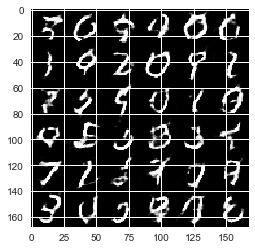

Epoch 1/2; d_loss: 0.7552; g_loss: 1.9549
Epoch 1/2; d_loss: 1.0151; g_loss: 0.6481
Epoch 1/2; d_loss: 1.0911; g_loss: 0.6353
Epoch 1/2; d_loss: 0.7007; g_loss: 1.3407
Epoch 1/2; d_loss: 0.7534; g_loss: 1.0024
Epoch 1/2; d_loss: 0.9716; g_loss: 0.7116
Epoch 1/2; d_loss: 1.7715; g_loss: 3.7756
Epoch 1/2; d_loss: 1.4316; g_loss: 0.4423
Epoch 1/2; d_loss: 0.9141; g_loss: 0.6813
Epoch 1/2; d_loss: 1.0327; g_loss: 0.5783
Epoch 1/2; d_loss: 1.6654; g_loss: 0.2859
Epoch 1/2; d_loss: 0.7466; g_loss: 0.9143
Epoch 1/2; d_loss: 2.2043; g_loss: 0.1861
Epoch 1/2; d_loss: 0.8560; g_loss: 0.7717
Epoch 1/2; d_loss: 0.9759; g_loss: 0.7663
Epoch 1/2; d_loss: 1.0540; g_loss: 0.6314
Epoch 1/2; d_loss: 2.8820; g_loss: 5.1540
Epoch 1/2; d_loss: 1.0955; g_loss: 0.8659
Epoch 1/2; d_loss: 0.9427; g_loss: 0.7579
Epoch 1/2; d_loss: 1.5753; g_loss: 0.2958


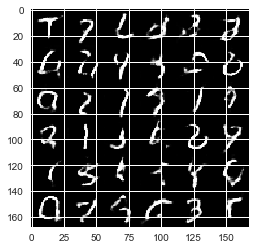

Epoch 1/2; d_loss: 0.6292; g_loss: 1.0674
Epoch 1/2; d_loss: 0.6706; g_loss: 1.1293
Epoch 1/2; d_loss: 0.6673; g_loss: 0.9723
Epoch 1/2; d_loss: 1.1994; g_loss: 0.5791
Epoch 1/2; d_loss: 0.5413; g_loss: 1.3287
Epoch 1/2; d_loss: 2.9448; g_loss: 0.0956
Epoch 1/2; d_loss: 0.9587; g_loss: 1.5181
Epoch 1/2; d_loss: 1.0144; g_loss: 1.7176
Epoch 1/2; d_loss: 1.4343; g_loss: 0.4538
Epoch 1/2; d_loss: 0.8940; g_loss: 1.1173
Epoch 1/2; d_loss: 1.4913; g_loss: 0.3534
Epoch 1/2; d_loss: 1.0768; g_loss: 0.5515
Epoch 1/2; d_loss: 0.8588; g_loss: 0.8124
Epoch 1/2; d_loss: 1.2188; g_loss: 0.4634
Epoch 1/2; d_loss: 0.9751; g_loss: 0.6734
Epoch 1/2; d_loss: 1.4988; g_loss: 0.3525
Epoch 1/2; d_loss: 0.5263; g_loss: 1.9528
Epoch 1/2; d_loss: 0.6124; g_loss: 1.0579
Epoch 1/2; d_loss: 1.9487; g_loss: 0.3226
Epoch 1/2; d_loss: 3.2621; g_loss: 0.0678


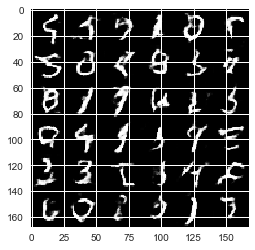

Epoch 1/2; d_loss: 0.4777; g_loss: 2.1286
Epoch 1/2; d_loss: 0.7275; g_loss: 1.0426
Epoch 1/2; d_loss: 1.1355; g_loss: 0.5693
Epoch 1/2; d_loss: 1.3539; g_loss: 0.4680
Epoch 1/2; d_loss: 0.7254; g_loss: 1.2744
Epoch 1/2; d_loss: 1.3828; g_loss: 0.4100
Epoch 1/2; d_loss: 0.7607; g_loss: 1.4083
Epoch 1/2; d_loss: 1.0731; g_loss: 0.5738
Epoch 1/2; d_loss: 0.4912; g_loss: 1.2204
Epoch 1/2; d_loss: 0.8604; g_loss: 3.0347
Epoch 1/2; d_loss: 0.9988; g_loss: 0.9648
Epoch 1/2; d_loss: 0.7541; g_loss: 1.1481
Epoch 1/2; d_loss: 0.6893; g_loss: 1.1519
Epoch 1/2; d_loss: 0.9227; g_loss: 0.6507
Epoch 1/2; d_loss: 0.7492; g_loss: 0.9607
Epoch 1/2; d_loss: 0.7694; g_loss: 0.9099
Epoch 1/2; d_loss: 0.6513; g_loss: 1.0862
Epoch 1/2; d_loss: 0.8634; g_loss: 0.7324
Epoch 1/2; d_loss: 0.9701; g_loss: 0.6281
Epoch 1/2; d_loss: 0.8779; g_loss: 0.6540


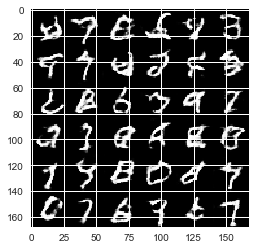

Epoch 1/2; d_loss: 0.7121; g_loss: 1.0061
Epoch 1/2; d_loss: 1.1000; g_loss: 0.5591
Epoch 1/2; d_loss: 1.1891; g_loss: 2.9260
Epoch 1/2; d_loss: 1.6614; g_loss: 0.3771
Epoch 1/2; d_loss: 0.6179; g_loss: 2.4068
Epoch 1/2; d_loss: 1.3764; g_loss: 0.4048
Epoch 1/2; d_loss: 1.4527; g_loss: 0.4168
Epoch 1/2; d_loss: 0.5930; g_loss: 1.1215
Epoch 1/2; d_loss: 1.0346; g_loss: 0.6144
Epoch 1/2; d_loss: 0.5333; g_loss: 1.2096
Epoch 1/2; d_loss: 0.9776; g_loss: 0.6238
Epoch 1/2; d_loss: 1.0013; g_loss: 0.5892
Epoch 1/2; d_loss: 0.6703; g_loss: 0.9844
Epoch 1/2; d_loss: 0.6019; g_loss: 1.1386
Epoch 1/2; d_loss: 0.8166; g_loss: 0.7954
Epoch 1/2; d_loss: 0.6936; g_loss: 0.9349
Epoch 1/2; d_loss: 0.5878; g_loss: 2.3200
Epoch 1/2; d_loss: 1.2939; g_loss: 3.8418
Epoch 1/2; d_loss: 0.7683; g_loss: 1.4881
Epoch 1/2; d_loss: 1.3900; g_loss: 0.4332


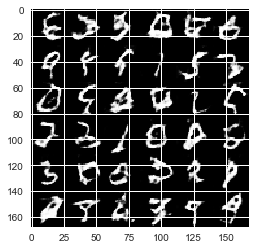

Epoch 1/2; d_loss: 1.1021; g_loss: 0.5747
Epoch 1/2; d_loss: 1.6619; g_loss: 0.2905
Epoch 1/2; d_loss: 3.1231; g_loss: 4.4693
Epoch 1/2; d_loss: 0.7736; g_loss: 0.9405
Epoch 1/2; d_loss: 0.6145; g_loss: 1.6038
Epoch 1/2; d_loss: 0.5566; g_loss: 1.7539
Epoch 1/2; d_loss: 1.3314; g_loss: 0.4501
Epoch 1/2; d_loss: 0.7892; g_loss: 0.7847
Epoch 1/2; d_loss: 0.5719; g_loss: 1.2680
Epoch 1/2; d_loss: 0.7293; g_loss: 1.0237
Epoch 1/2; d_loss: 0.6179; g_loss: 1.0340
Epoch 1/2; d_loss: 0.9126; g_loss: 0.6590
Epoch 1/2; d_loss: 0.7137; g_loss: 0.8766
Epoch 1/2; d_loss: 0.9375; g_loss: 0.6419
Epoch 1/2; d_loss: 0.4964; g_loss: 1.4806
Epoch 1/2; d_loss: 0.8837; g_loss: 0.6904
Epoch 1/2; d_loss: 0.4853; g_loss: 1.3146
Epoch 1/2; d_loss: 1.1457; g_loss: 0.5391
Epoch 1/2; d_loss: 0.8304; g_loss: 0.8163
Epoch 1/2; d_loss: 0.6000; g_loss: 1.1592


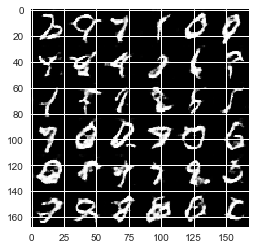

Epoch 1/2; d_loss: 1.3469; g_loss: 0.3807
Epoch 1/2; d_loss: 0.9383; g_loss: 0.7103
Epoch 1/2; d_loss: 4.9219; g_loss: 6.7132
Epoch 1/2; d_loss: 1.0790; g_loss: 3.3173
Epoch 1/2; d_loss: 0.9403; g_loss: 0.8766
Epoch 1/2; d_loss: 0.5549; g_loss: 1.1706
Epoch 1/2; d_loss: 0.4753; g_loss: 1.2967
Epoch 1/2; d_loss: 0.6669; g_loss: 1.0549
Epoch 1/2; d_loss: 1.0079; g_loss: 0.6846
Epoch 1/2; d_loss: 2.1090; g_loss: 0.1827
Epoch 1/2; d_loss: 0.8366; g_loss: 1.6632
Epoch 1/2; d_loss: 0.7760; g_loss: 2.0265
Epoch 1/2; d_loss: 1.2600; g_loss: 0.4651
Epoch 1/2; d_loss: 1.4807; g_loss: 0.3815
Epoch 1/2; d_loss: 0.6497; g_loss: 1.1146
Epoch 1/2; d_loss: 0.6477; g_loss: 1.3086
Epoch 1/2; d_loss: 1.3447; g_loss: 0.4348
Epoch 1/2; d_loss: 0.8983; g_loss: 0.6906
Epoch 1/2; d_loss: 0.7327; g_loss: 0.8692
Epoch 1/2; d_loss: 1.5552; g_loss: 0.3309


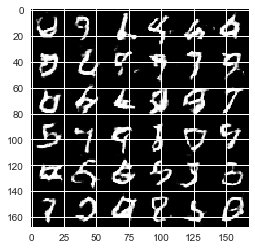

Epoch 1/2; d_loss: 0.9350; g_loss: 0.8153
Epoch 1/2; d_loss: 0.8539; g_loss: 2.5238
Epoch 1/2; d_loss: 1.5339; g_loss: 0.3270
Epoch 1/2; d_loss: 0.9668; g_loss: 0.7610
Epoch 1/2; d_loss: 0.7108; g_loss: 1.0738
Epoch 1/2; d_loss: 1.0110; g_loss: 0.6029
Epoch 1/2; d_loss: 0.6950; g_loss: 1.2599
Epoch 1/2; d_loss: 1.8632; g_loss: 0.2482
Epoch 1/2; d_loss: 1.0590; g_loss: 1.8186
Epoch 1/2; d_loss: 0.7448; g_loss: 1.5280
Epoch 1/2; d_loss: 0.7810; g_loss: 1.2845
Epoch 1/2; d_loss: 1.7212; g_loss: 0.2709
Epoch 1/2; d_loss: 0.6642; g_loss: 1.0886
Epoch 1/2; d_loss: 1.2716; g_loss: 0.4683
Epoch 1/2; d_loss: 0.6699; g_loss: 1.0654
Epoch 1/2; d_loss: 0.5644; g_loss: 1.1687
Epoch 1/2; d_loss: 0.5932; g_loss: 1.1513
Epoch 1/2; d_loss: 0.5774; g_loss: 1.2983
Epoch 1/2; d_loss: 0.7679; g_loss: 0.8889
Epoch 1/2; d_loss: 0.6042; g_loss: 1.3013


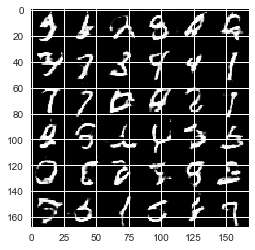

Epoch 1/2; d_loss: 0.9572; g_loss: 0.6597
Epoch 1/2; d_loss: 0.7974; g_loss: 0.8453
Epoch 1/2; d_loss: 0.5149; g_loss: 1.3653
Epoch 1/2; d_loss: 0.4240; g_loss: 1.5327
Epoch 1/2; d_loss: 0.7564; g_loss: 0.8306
Epoch 1/2; d_loss: 0.6831; g_loss: 1.0793
Epoch 1/2; d_loss: 0.3530; g_loss: 1.7885
Epoch 1/2; d_loss: 0.7136; g_loss: 1.3459
Epoch 1/2; d_loss: 0.9326; g_loss: 0.7414
Epoch 1/2; d_loss: 0.5507; g_loss: 1.5580
Epoch 1/2; d_loss: 0.6618; g_loss: 2.2407
Epoch 1/2; d_loss: 0.4623; g_loss: 1.4879
Epoch 1/2; d_loss: 0.8701; g_loss: 3.1811
Epoch 1/2; d_loss: 0.6974; g_loss: 1.5221
Epoch 1/2; d_loss: 1.3540; g_loss: 2.5854
Epoch 1/2; d_loss: 0.9861; g_loss: 0.6073
Epoch 1/2; d_loss: 0.6624; g_loss: 1.4074
Epoch 1/2; d_loss: 0.7216; g_loss: 3.2332
Epoch 1/2; d_loss: 1.5219; g_loss: 0.4101
Epoch 1/2; d_loss: 0.3899; g_loss: 1.5202


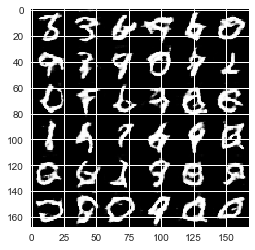

Epoch 1/2; d_loss: 0.4447; g_loss: 1.3847
Epoch 1/2; d_loss: 1.0949; g_loss: 0.5119
Epoch 1/2; d_loss: 0.4841; g_loss: 1.4413
Epoch 1/2; d_loss: 0.8285; g_loss: 0.7881
Epoch 1/2; d_loss: 0.3780; g_loss: 1.5177
Epoch 1/2; d_loss: 0.5269; g_loss: 1.2439
Epoch 1/2; d_loss: 0.8365; g_loss: 0.7313
Epoch 1/2; d_loss: 0.3064; g_loss: 1.6664
Epoch 1/2; d_loss: 1.4947; g_loss: 0.4463
Epoch 1/2; d_loss: 1.0135; g_loss: 1.7503
Epoch 1/2; d_loss: 1.9868; g_loss: 2.4158
Epoch 1/2; d_loss: 1.2025; g_loss: 0.5836
Epoch 1/2; d_loss: 1.3302; g_loss: 0.4479
Epoch 1/2; d_loss: 0.8052; g_loss: 1.2772
Epoch 1/2; d_loss: 0.7572; g_loss: 1.2296
Epoch 1/2; d_loss: 0.9209; g_loss: 0.8495
Epoch 1/2; d_loss: 0.8220; g_loss: 1.2122
Epoch 1/2; d_loss: 0.8561; g_loss: 0.8722
Epoch 1/2; d_loss: 0.7165; g_loss: 1.0962
Epoch 1/2; d_loss: 1.2542; g_loss: 0.4989


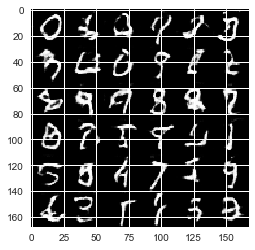

Epoch 1/2; d_loss: 0.7634; g_loss: 0.8165
Epoch 1/2; d_loss: 0.6373; g_loss: 1.3465
Epoch 1/2; d_loss: 0.4776; g_loss: 2.0853
Epoch 1/2; d_loss: 1.1802; g_loss: 0.5521
Epoch 1/2; d_loss: 0.6615; g_loss: 1.1301
Epoch 1/2; d_loss: 0.6430; g_loss: 1.1903
Epoch 1/2; d_loss: 0.8523; g_loss: 0.7341
Epoch 1/2; d_loss: 0.2729; g_loss: 1.9602
Epoch 1/2; d_loss: 0.5006; g_loss: 1.3742
Epoch 1/2; d_loss: 0.3565; g_loss: 1.9446
Epoch 1/2; d_loss: 0.6363; g_loss: 1.0408
Epoch 1/2; d_loss: 0.4870; g_loss: 1.2494
Epoch 1/2; d_loss: 1.1043; g_loss: 0.6499
Epoch 1/2; d_loss: 2.3402; g_loss: 0.1494
Epoch 1/2; d_loss: 0.5758; g_loss: 1.2265
Epoch 1/2; d_loss: 0.5157; g_loss: 1.4646
Epoch 1/2; d_loss: 0.5735; g_loss: 1.4247
Epoch 1/2; d_loss: 0.5672; g_loss: 1.2854
Epoch 1/2; d_loss: 0.8662; g_loss: 0.7950
Epoch 1/2; d_loss: 0.5971; g_loss: 1.2132


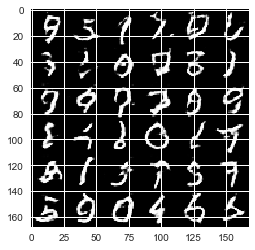

Epoch 1/2; d_loss: 0.2130; g_loss: 2.2302
Epoch 1/2; d_loss: 0.3471; g_loss: 1.6982
Epoch 1/2; d_loss: 2.2576; g_loss: 0.1950
Epoch 1/2; d_loss: 0.8970; g_loss: 2.9848
Epoch 1/2; d_loss: 0.9508; g_loss: 0.8675
Epoch 1/2; d_loss: 0.8275; g_loss: 1.0268
Epoch 1/2; d_loss: 0.3452; g_loss: 1.5850
Epoch 1/2; d_loss: 0.8046; g_loss: 2.4275
Epoch 1/2; d_loss: 0.8767; g_loss: 1.3341
Epoch 1/2; d_loss: 0.7499; g_loss: 0.9395
Epoch 1/2; d_loss: 0.9224; g_loss: 0.6998
Epoch 1/2; d_loss: 0.8699; g_loss: 2.4082
Epoch 1/2; d_loss: 0.8434; g_loss: 0.8944
Epoch 1/2; d_loss: 0.6903; g_loss: 2.0479
Epoch 1/2; d_loss: 0.4423; g_loss: 1.4932
Epoch 1/2; d_loss: 0.5188; g_loss: 1.3555
Epoch 1/2; d_loss: 0.5803; g_loss: 1.2646
Epoch 1/2; d_loss: 0.4326; g_loss: 1.6171
Epoch 1/2; d_loss: 1.3177; g_loss: 3.4471
Epoch 1/2; d_loss: 0.3451; g_loss: 1.7529


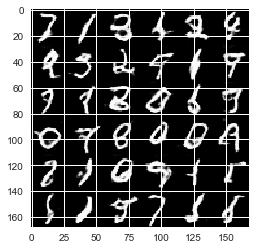

Epoch 1/2; d_loss: 0.7812; g_loss: 1.6073
Epoch 1/2; d_loss: 0.4495; g_loss: 1.5760
Epoch 1/2; d_loss: 0.6751; g_loss: 1.2230
Epoch 1/2; d_loss: 0.6251; g_loss: 1.2060
Epoch 1/2; d_loss: 0.4414; g_loss: 2.8170
Epoch 1/2; d_loss: 0.6207; g_loss: 1.2442
Epoch 1/2; d_loss: 0.5074; g_loss: 2.5070
Epoch 1/2; d_loss: 0.3484; g_loss: 1.9413
Epoch 1/2; d_loss: 0.3684; g_loss: 2.0682
Epoch 1/2; d_loss: 0.3311; g_loss: 2.0058
Epoch 1/2; d_loss: 0.5214; g_loss: 1.2227
Epoch 1/2; d_loss: 1.1132; g_loss: 0.6126
Epoch 1/2; d_loss: 1.1586; g_loss: 0.5596
Epoch 1/2; d_loss: 0.5640; g_loss: 1.2138
Epoch 1/2; d_loss: 0.6402; g_loss: 1.0199
Epoch 2/2; d_loss: 0.3186; g_loss: 1.8215
Epoch 2/2; d_loss: 1.7070; g_loss: 0.3080
Epoch 2/2; d_loss: 0.5948; g_loss: 3.0560
Epoch 2/2; d_loss: 0.7306; g_loss: 1.0271
Epoch 2/2; d_loss: 0.9096; g_loss: 0.6654


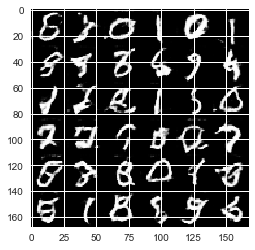

Epoch 2/2; d_loss: 1.3614; g_loss: 0.4288
Epoch 2/2; d_loss: 1.1064; g_loss: 0.5437
Epoch 2/2; d_loss: 0.6652; g_loss: 1.0901
Epoch 2/2; d_loss: 0.5979; g_loss: 1.1490
Epoch 2/2; d_loss: 0.3487; g_loss: 2.4922
Epoch 2/2; d_loss: 1.0490; g_loss: 0.6496
Epoch 2/2; d_loss: 0.7977; g_loss: 0.9130
Epoch 2/2; d_loss: 0.4661; g_loss: 2.0350
Epoch 2/2; d_loss: 0.7191; g_loss: 0.8477
Epoch 2/2; d_loss: 0.3680; g_loss: 1.5908
Epoch 2/2; d_loss: 0.3276; g_loss: 1.6589
Epoch 2/2; d_loss: 0.4254; g_loss: 1.4007
Epoch 2/2; d_loss: 0.1895; g_loss: 2.6114
Epoch 2/2; d_loss: 1.0909; g_loss: 0.6650
Epoch 2/2; d_loss: 0.5211; g_loss: 3.3066
Epoch 2/2; d_loss: 1.0836; g_loss: 0.8140
Epoch 2/2; d_loss: 0.7062; g_loss: 1.3431
Epoch 2/2; d_loss: 0.5625; g_loss: 1.4369
Epoch 2/2; d_loss: 1.7668; g_loss: 0.2913
Epoch 2/2; d_loss: 0.4912; g_loss: 1.3870


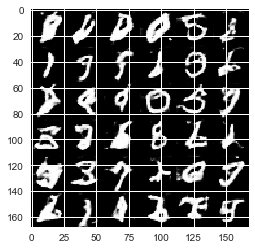

Epoch 2/2; d_loss: 1.2088; g_loss: 0.5674
Epoch 2/2; d_loss: 0.3845; g_loss: 1.5040
Epoch 2/2; d_loss: 0.8243; g_loss: 0.8776
Epoch 2/2; d_loss: 0.5270; g_loss: 1.2575
Epoch 2/2; d_loss: 0.7782; g_loss: 0.9317
Epoch 2/2; d_loss: 0.5101; g_loss: 1.2846
Epoch 2/2; d_loss: 0.3132; g_loss: 1.9647
Epoch 2/2; d_loss: 0.4000; g_loss: 1.6735
Epoch 2/2; d_loss: 1.4191; g_loss: 0.4016
Epoch 2/2; d_loss: 0.8873; g_loss: 4.2119
Epoch 2/2; d_loss: 0.9053; g_loss: 0.7580
Epoch 2/2; d_loss: 0.3057; g_loss: 2.0540
Epoch 2/2; d_loss: 0.1892; g_loss: 2.4106
Epoch 2/2; d_loss: 0.2219; g_loss: 1.9662
Epoch 2/2; d_loss: 0.6543; g_loss: 1.0388
Epoch 2/2; d_loss: 0.1649; g_loss: 3.3543
Epoch 2/2; d_loss: 1.8480; g_loss: 0.2144
Epoch 2/2; d_loss: 0.3441; g_loss: 1.5368
Epoch 2/2; d_loss: 0.3638; g_loss: 1.6233
Epoch 2/2; d_loss: 0.3255; g_loss: 1.9520


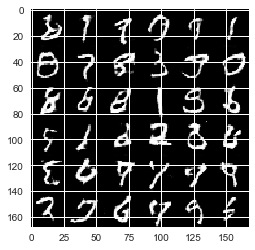

Epoch 2/2; d_loss: 0.2270; g_loss: 2.1115
Epoch 2/2; d_loss: 1.3638; g_loss: 0.4747
Epoch 2/2; d_loss: 0.4893; g_loss: 1.4962
Epoch 2/2; d_loss: 0.3700; g_loss: 1.6658
Epoch 2/2; d_loss: 0.3075; g_loss: 2.0260
Epoch 2/2; d_loss: 0.5332; g_loss: 1.2715
Epoch 2/2; d_loss: 0.4602; g_loss: 1.6037
Epoch 2/2; d_loss: 0.7810; g_loss: 0.9311
Epoch 2/2; d_loss: 0.4001; g_loss: 1.6596
Epoch 2/2; d_loss: 0.7858; g_loss: 0.8982
Epoch 2/2; d_loss: 0.4435; g_loss: 1.4287
Epoch 2/2; d_loss: 0.2675; g_loss: 2.1854
Epoch 2/2; d_loss: 0.4733; g_loss: 1.5041
Epoch 2/2; d_loss: 0.4654; g_loss: 1.4349
Epoch 2/2; d_loss: 0.9183; g_loss: 0.8924
Epoch 2/2; d_loss: 0.2464; g_loss: 2.5960
Epoch 2/2; d_loss: 0.4144; g_loss: 1.4482
Epoch 2/2; d_loss: 0.3577; g_loss: 1.6735
Epoch 2/2; d_loss: 0.5796; g_loss: 1.1046
Epoch 2/2; d_loss: 0.3091; g_loss: 1.7733


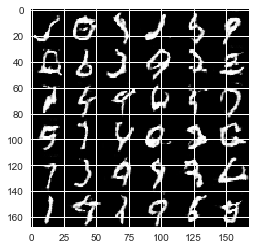

Epoch 2/2; d_loss: 0.5313; g_loss: 1.1748
Epoch 2/2; d_loss: 0.5169; g_loss: 1.3438
Epoch 2/2; d_loss: 0.8816; g_loss: 0.7320
Epoch 2/2; d_loss: 0.5126; g_loss: 1.2658
Epoch 2/2; d_loss: 0.4225; g_loss: 1.4912
Epoch 2/2; d_loss: 0.2705; g_loss: 3.1567
Epoch 2/2; d_loss: 1.8607; g_loss: 5.9604
Epoch 2/2; d_loss: 0.6211; g_loss: 1.9930
Epoch 2/2; d_loss: 1.7874; g_loss: 0.4172
Epoch 2/2; d_loss: 0.5817; g_loss: 1.2940
Epoch 2/2; d_loss: 1.7865; g_loss: 0.2765
Epoch 2/2; d_loss: 0.4784; g_loss: 1.7134
Epoch 2/2; d_loss: 0.5182; g_loss: 1.3785
Epoch 2/2; d_loss: 0.4029; g_loss: 2.1714
Epoch 2/2; d_loss: 0.4370; g_loss: 1.5004
Epoch 2/2; d_loss: 0.3988; g_loss: 1.5493
Epoch 2/2; d_loss: 1.4581; g_loss: 0.4904
Epoch 2/2; d_loss: 1.0628; g_loss: 4.7198
Epoch 2/2; d_loss: 0.3532; g_loss: 2.5281
Epoch 2/2; d_loss: 0.4534; g_loss: 1.4910


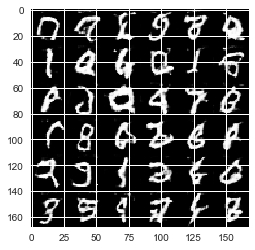

Epoch 2/2; d_loss: 0.7913; g_loss: 0.9087
Epoch 2/2; d_loss: 0.3885; g_loss: 2.4516
Epoch 2/2; d_loss: 1.8217; g_loss: 0.2414
Epoch 2/2; d_loss: 5.1068; g_loss: 8.7680
Epoch 2/2; d_loss: 0.4406; g_loss: 1.7842
Epoch 2/2; d_loss: 0.7669; g_loss: 0.8811
Epoch 2/2; d_loss: 0.5458; g_loss: 1.1948
Epoch 2/2; d_loss: 0.5987; g_loss: 1.0841
Epoch 2/2; d_loss: 0.4642; g_loss: 1.6583
Epoch 2/2; d_loss: 0.2811; g_loss: 1.7796
Epoch 2/2; d_loss: 0.3152; g_loss: 1.9987
Epoch 2/2; d_loss: 0.3144; g_loss: 1.8356
Epoch 2/2; d_loss: 0.6709; g_loss: 0.9821
Epoch 2/2; d_loss: 0.6884; g_loss: 0.9001
Epoch 2/2; d_loss: 0.3452; g_loss: 1.4775
Epoch 2/2; d_loss: 0.4707; g_loss: 1.3815
Epoch 2/2; d_loss: 0.3983; g_loss: 1.6191
Epoch 2/2; d_loss: 0.1901; g_loss: 2.3745
Epoch 2/2; d_loss: 0.1782; g_loss: 2.5335
Epoch 2/2; d_loss: 0.4826; g_loss: 1.3207


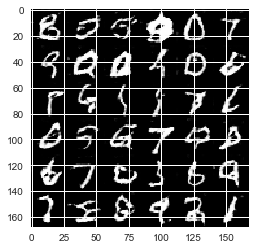

Epoch 2/2; d_loss: 0.1650; g_loss: 2.7875
Epoch 2/2; d_loss: 0.3046; g_loss: 3.0082
Epoch 2/2; d_loss: 0.5953; g_loss: 1.1592
Epoch 2/2; d_loss: 0.2872; g_loss: 2.3887
Epoch 2/2; d_loss: 0.1510; g_loss: 2.7648
Epoch 2/2; d_loss: 0.1624; g_loss: 2.6688
Epoch 2/2; d_loss: 0.6362; g_loss: 1.1835
Epoch 2/2; d_loss: 0.5162; g_loss: 1.4384
Epoch 2/2; d_loss: 0.2046; g_loss: 2.3021
Epoch 2/2; d_loss: 0.7466; g_loss: 1.0203
Epoch 2/2; d_loss: 0.3880; g_loss: 1.7372
Epoch 2/2; d_loss: 1.4880; g_loss: 0.5907
Epoch 2/2; d_loss: 2.9616; g_loss: 5.1048
Epoch 2/2; d_loss: 0.8140; g_loss: 1.2317
Epoch 2/2; d_loss: 0.9093; g_loss: 2.0993
Epoch 2/2; d_loss: 0.5685; g_loss: 1.6117
Epoch 2/2; d_loss: 0.5650; g_loss: 1.3549
Epoch 2/2; d_loss: 0.6440; g_loss: 2.0562
Epoch 2/2; d_loss: 0.5685; g_loss: 1.4625
Epoch 2/2; d_loss: 0.7886; g_loss: 0.8330


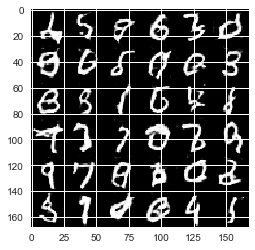

Epoch 2/2; d_loss: 0.6359; g_loss: 2.5411
Epoch 2/2; d_loss: 0.4772; g_loss: 1.9582
Epoch 2/2; d_loss: 0.4049; g_loss: 2.1208
Epoch 2/2; d_loss: 0.8839; g_loss: 0.9118
Epoch 2/2; d_loss: 0.4001; g_loss: 1.5649
Epoch 2/2; d_loss: 0.5457; g_loss: 1.2101
Epoch 2/2; d_loss: 0.4600; g_loss: 1.3594
Epoch 2/2; d_loss: 0.6211; g_loss: 1.0313
Epoch 2/2; d_loss: 0.5492; g_loss: 1.2041
Epoch 2/2; d_loss: 0.4926; g_loss: 1.2906
Epoch 2/2; d_loss: 0.5543; g_loss: 1.3000
Epoch 2/2; d_loss: 0.8686; g_loss: 0.8133
Epoch 2/2; d_loss: 0.3217; g_loss: 1.7129
Epoch 2/2; d_loss: 0.3185; g_loss: 1.8420
Epoch 2/2; d_loss: 0.2725; g_loss: 1.9465
Epoch 2/2; d_loss: 0.4064; g_loss: 1.6007
Epoch 2/2; d_loss: 0.3233; g_loss: 1.8309
Epoch 2/2; d_loss: 0.4222; g_loss: 1.3918
Epoch 2/2; d_loss: 0.2785; g_loss: 1.8452
Epoch 2/2; d_loss: 0.3929; g_loss: 1.6927


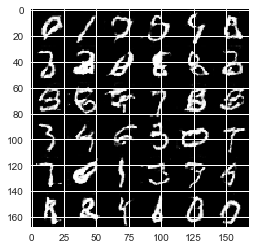

Epoch 2/2; d_loss: 0.7195; g_loss: 1.0031
Epoch 2/2; d_loss: 0.3248; g_loss: 1.7561
Epoch 2/2; d_loss: 0.1425; g_loss: 2.6165
Epoch 2/2; d_loss: 0.3477; g_loss: 1.6593
Epoch 2/2; d_loss: 0.5033; g_loss: 4.6011
Epoch 2/2; d_loss: 0.2656; g_loss: 3.9758
Epoch 2/2; d_loss: 0.2625; g_loss: 1.7742
Epoch 2/2; d_loss: 1.5040; g_loss: 0.4056
Epoch 2/2; d_loss: 0.4316; g_loss: 1.6945
Epoch 2/2; d_loss: 0.3730; g_loss: 2.3942
Epoch 2/2; d_loss: 0.4101; g_loss: 1.6588
Epoch 2/2; d_loss: 0.3863; g_loss: 1.7999
Epoch 2/2; d_loss: 0.7419; g_loss: 0.8416
Epoch 2/2; d_loss: 0.2781; g_loss: 1.9074
Epoch 2/2; d_loss: 0.3192; g_loss: 1.9034
Epoch 2/2; d_loss: 0.1826; g_loss: 2.4975
Epoch 2/2; d_loss: 0.3314; g_loss: 1.8516
Epoch 2/2; d_loss: 0.2802; g_loss: 1.9121
Epoch 2/2; d_loss: 0.4977; g_loss: 1.3388
Epoch 2/2; d_loss: 0.2080; g_loss: 2.4058


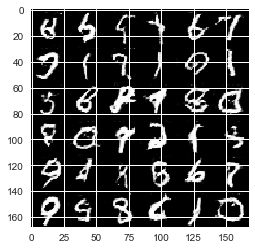

Epoch 2/2; d_loss: 0.3331; g_loss: 2.0020
Epoch 2/2; d_loss: 0.1974; g_loss: 2.2558
Epoch 2/2; d_loss: 0.2561; g_loss: 2.1818
Epoch 2/2; d_loss: 0.6460; g_loss: 1.1689
Epoch 2/2; d_loss: 0.2091; g_loss: 2.3380
Epoch 2/2; d_loss: 0.4238; g_loss: 1.3534
Epoch 2/2; d_loss: 0.4881; g_loss: 1.4252
Epoch 2/2; d_loss: 0.5557; g_loss: 1.1945
Epoch 2/2; d_loss: 0.2424; g_loss: 2.1743
Epoch 2/2; d_loss: 0.1477; g_loss: 4.3115
Epoch 2/2; d_loss: 0.4687; g_loss: 1.2749
Epoch 2/2; d_loss: 3.2894; g_loss: 0.1149
Epoch 2/2; d_loss: 1.5270; g_loss: 0.3649
Epoch 2/2; d_loss: 1.8442; g_loss: 5.7096
Epoch 2/2; d_loss: 0.3132; g_loss: 2.2373
Epoch 2/2; d_loss: 0.2867; g_loss: 2.2355
Epoch 2/2; d_loss: 0.3494; g_loss: 2.1465
Epoch 2/2; d_loss: 0.3276; g_loss: 1.9531
Epoch 2/2; d_loss: 1.0984; g_loss: 0.6863
Epoch 2/2; d_loss: 3.0856; g_loss: 5.3828


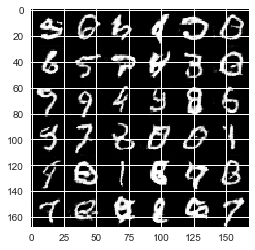

Epoch 2/2; d_loss: 0.5714; g_loss: 1.6967
Epoch 2/2; d_loss: 0.5672; g_loss: 3.0175
Epoch 2/2; d_loss: 0.9437; g_loss: 0.8024
Epoch 2/2; d_loss: 0.4154; g_loss: 1.4146
Epoch 2/2; d_loss: 0.5739; g_loss: 1.3754
Epoch 2/2; d_loss: 0.3079; g_loss: 2.1249
Epoch 2/2; d_loss: 0.3634; g_loss: 1.6622
Epoch 2/2; d_loss: 0.2798; g_loss: 2.3072
Epoch 2/2; d_loss: 0.2918; g_loss: 2.0141
Epoch 2/2; d_loss: 0.4738; g_loss: 1.4658
Epoch 2/2; d_loss: 0.3286; g_loss: 1.8546
Epoch 2/2; d_loss: 0.5024; g_loss: 1.5506
Epoch 2/2; d_loss: 0.5314; g_loss: 1.3203
Epoch 2/2; d_loss: 0.4062; g_loss: 1.7472
Epoch 2/2; d_loss: 0.1178; g_loss: 3.9762
Epoch 2/2; d_loss: 0.2763; g_loss: 1.9238
Epoch 2/2; d_loss: 0.2539; g_loss: 2.2182
Epoch 2/2; d_loss: 0.4504; g_loss: 1.3804
Epoch 2/2; d_loss: 0.2029; g_loss: 2.3703
Epoch 2/2; d_loss: 0.3034; g_loss: 2.6757


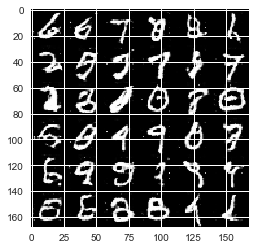

Epoch 2/2; d_loss: 0.6172; g_loss: 1.2455
Epoch 2/2; d_loss: 1.2330; g_loss: 4.5997
Epoch 2/2; d_loss: 1.1667; g_loss: 4.4945
Epoch 2/2; d_loss: 1.3699; g_loss: 0.4277
Epoch 2/2; d_loss: 0.2899; g_loss: 2.7484
Epoch 2/2; d_loss: 0.7467; g_loss: 1.1540
Epoch 2/2; d_loss: 0.6555; g_loss: 1.0110
Epoch 2/2; d_loss: 1.3059; g_loss: 0.5158
Epoch 2/2; d_loss: 0.4092; g_loss: 1.6392
Epoch 2/2; d_loss: 0.4764; g_loss: 1.2981
Epoch 2/2; d_loss: 0.4869; g_loss: 1.4624
Epoch 2/2; d_loss: 0.3989; g_loss: 1.4518
Epoch 2/2; d_loss: 0.1875; g_loss: 2.3181
Epoch 2/2; d_loss: 0.7743; g_loss: 0.9816
Epoch 2/2; d_loss: 0.2443; g_loss: 2.0527
Epoch 2/2; d_loss: 0.4676; g_loss: 1.4688
Epoch 2/2; d_loss: 0.3813; g_loss: 2.6453
Epoch 2/2; d_loss: 1.5711; g_loss: 0.4008
Epoch 2/2; d_loss: 0.3474; g_loss: 2.7059
Epoch 2/2; d_loss: 0.5300; g_loss: 3.4611


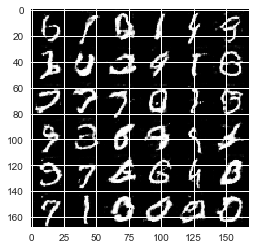

Epoch 2/2; d_loss: 1.0406; g_loss: 0.9416
Epoch 2/2; d_loss: 0.5187; g_loss: 1.3978
Epoch 2/2; d_loss: 0.2633; g_loss: 1.9666
Epoch 2/2; d_loss: 0.5846; g_loss: 1.1351
Epoch 2/2; d_loss: 0.5391; g_loss: 1.1631
Epoch 2/2; d_loss: 0.3810; g_loss: 1.6813
Epoch 2/2; d_loss: 0.4059; g_loss: 3.8420
Epoch 2/2; d_loss: 0.5191; g_loss: 1.2869
Epoch 2/2; d_loss: 0.3658; g_loss: 1.6643
Epoch 2/2; d_loss: 0.3125; g_loss: 1.9838
Epoch 2/2; d_loss: 0.2691; g_loss: 1.9488
Epoch 2/2; d_loss: 0.3453; g_loss: 1.8576
Epoch 2/2; d_loss: 0.3933; g_loss: 1.6279
Epoch 2/2; d_loss: 0.2175; g_loss: 2.0837
Epoch 2/2; d_loss: 0.5118; g_loss: 1.4915
Epoch 2/2; d_loss: 0.1860; g_loss: 2.4421
Epoch 2/2; d_loss: 0.3375; g_loss: 1.6852
Epoch 2/2; d_loss: 0.3581; g_loss: 3.5388
Epoch 2/2; d_loss: 0.7014; g_loss: 1.1413
Epoch 2/2; d_loss: 0.5222; g_loss: 1.3350


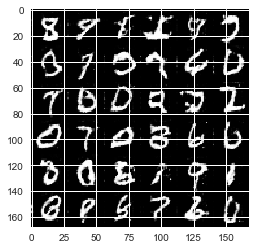

Epoch 2/2; d_loss: 0.6282; g_loss: 1.2217
Epoch 2/2; d_loss: 0.2294; g_loss: 2.1518
Epoch 2/2; d_loss: 0.1502; g_loss: 2.6758
Epoch 2/2; d_loss: 0.4210; g_loss: 1.7589
Epoch 2/2; d_loss: 1.7141; g_loss: 0.6100
Epoch 2/2; d_loss: 0.7460; g_loss: 1.0321
Epoch 2/2; d_loss: 0.5614; g_loss: 1.2491
Epoch 2/2; d_loss: 0.6242; g_loss: 1.4782
Epoch 2/2; d_loss: 0.5097; g_loss: 1.6933
Epoch 2/2; d_loss: 0.6040; g_loss: 1.2316
Epoch 2/2; d_loss: 0.2675; g_loss: 2.4575
Epoch 2/2; d_loss: 0.5522; g_loss: 1.1605
Epoch 2/2; d_loss: 0.2957; g_loss: 2.0372
Epoch 2/2; d_loss: 0.6280; g_loss: 1.1684
Epoch 2/2; d_loss: 1.1904; g_loss: 0.5596
Epoch 2/2; d_loss: 0.5425; g_loss: 1.3690
Epoch 2/2; d_loss: 0.4721; g_loss: 1.5828
Epoch 2/2; d_loss: 0.9805; g_loss: 0.7931
Epoch 2/2; d_loss: 0.8651; g_loss: 2.8571
Epoch 2/2; d_loss: 1.4850; g_loss: 0.8115


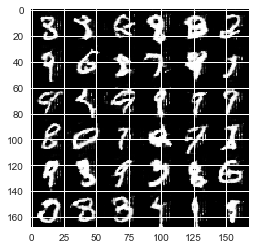

Epoch 2/2; d_loss: 1.9511; g_loss: 3.0143
Epoch 2/2; d_loss: 0.9698; g_loss: 0.8904
Epoch 2/2; d_loss: 1.6629; g_loss: 0.2941
Epoch 2/2; d_loss: 1.4745; g_loss: 0.4349
Epoch 2/2; d_loss: 1.0434; g_loss: 0.6361
Epoch 2/2; d_loss: 0.8695; g_loss: 2.6948
Epoch 2/2; d_loss: 0.8539; g_loss: 1.0420
Epoch 2/2; d_loss: 0.5580; g_loss: 2.6440
Epoch 2/2; d_loss: 1.0490; g_loss: 0.8414
Epoch 2/2; d_loss: 0.7132; g_loss: 1.0840
Epoch 2/2; d_loss: 0.4572; g_loss: 1.4638
Epoch 2/2; d_loss: 0.4768; g_loss: 1.3891
Epoch 2/2; d_loss: 0.6786; g_loss: 1.0757
Epoch 2/2; d_loss: 0.7034; g_loss: 1.0260
Epoch 2/2; d_loss: 0.9593; g_loss: 0.9482
Epoch 2/2; d_loss: 0.4218; g_loss: 1.7627
Epoch 2/2; d_loss: 0.5940; g_loss: 1.3277
Epoch 2/2; d_loss: 0.9800; g_loss: 0.8771
Epoch 2/2; d_loss: 0.6661; g_loss: 1.4119
Epoch 2/2; d_loss: 1.5112; g_loss: 5.3512


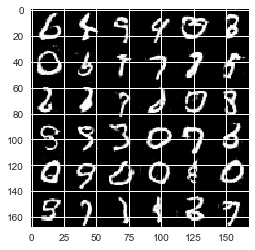

Epoch 2/2; d_loss: 0.3142; g_loss: 2.4151
Epoch 2/2; d_loss: 0.3699; g_loss: 1.7344
Epoch 2/2; d_loss: 0.9253; g_loss: 0.6959
Epoch 2/2; d_loss: 0.1661; g_loss: 2.6151
Epoch 2/2; d_loss: 0.2972; g_loss: 1.7559
Epoch 2/2; d_loss: 0.4288; g_loss: 1.5357
Epoch 2/2; d_loss: 0.3592; g_loss: 1.7017
Epoch 2/2; d_loss: 0.2958; g_loss: 1.8909
Epoch 2/2; d_loss: 0.4518; g_loss: 1.3968
Epoch 2/2; d_loss: 0.3726; g_loss: 1.6446
Epoch 2/2; d_loss: 0.3284; g_loss: 1.9033
Epoch 2/2; d_loss: 0.3669; g_loss: 1.4639
Epoch 2/2; d_loss: 0.4301; g_loss: 1.6671
Epoch 2/2; d_loss: 0.9347; g_loss: 0.7654
Epoch 2/2; d_loss: 0.8213; g_loss: 0.8190
Epoch 2/2; d_loss: 0.2551; g_loss: 2.2683
Epoch 2/2; d_loss: 1.4684; g_loss: 0.4043
Epoch 2/2; d_loss: 1.1496; g_loss: 0.6848
Epoch 2/2; d_loss: 0.3784; g_loss: 3.1559
Epoch 2/2; d_loss: 0.7327; g_loss: 1.0518


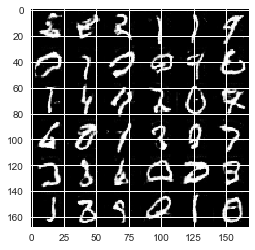

Epoch 2/2; d_loss: 0.6521; g_loss: 1.0934
Epoch 2/2; d_loss: 0.5284; g_loss: 1.2964
Epoch 2/2; d_loss: 0.7857; g_loss: 0.8902
Epoch 2/2; d_loss: 0.7568; g_loss: 0.8971
Epoch 2/2; d_loss: 0.6025; g_loss: 1.2881
Epoch 2/2; d_loss: 1.0312; g_loss: 0.6132
Epoch 2/2; d_loss: 0.8784; g_loss: 0.8621
Epoch 2/2; d_loss: 0.4305; g_loss: 1.5381
Epoch 2/2; d_loss: 0.5709; g_loss: 1.2740
Epoch 2/2; d_loss: 0.4607; g_loss: 1.2816
Epoch 2/2; d_loss: 0.5745; g_loss: 1.1816
Epoch 2/2; d_loss: 0.3645; g_loss: 1.9829
Epoch 2/2; d_loss: 4.1708; g_loss: 0.0754
Epoch 2/2; d_loss: 0.3920; g_loss: 2.4976
Epoch 2/2; d_loss: 0.6335; g_loss: 1.4107
Epoch 2/2; d_loss: 0.9155; g_loss: 0.7594
Epoch 2/2; d_loss: 0.7095; g_loss: 3.2033
Epoch 2/2; d_loss: 0.7035; g_loss: 3.8232
Epoch 2/2; d_loss: 2.5133; g_loss: 0.1693
Epoch 2/2; d_loss: 0.6610; g_loss: 1.1753


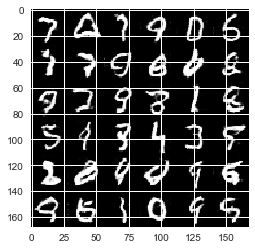

Epoch 2/2; d_loss: 0.6052; g_loss: 1.3199
Epoch 2/2; d_loss: 0.4889; g_loss: 1.5196
Epoch 2/2; d_loss: 0.4329; g_loss: 1.5373
Epoch 2/2; d_loss: 0.6114; g_loss: 1.1268
Epoch 2/2; d_loss: 0.3001; g_loss: 1.7871
Epoch 2/2; d_loss: 0.5328; g_loss: 1.3551
Epoch 2/2; d_loss: 0.2659; g_loss: 1.9401
Epoch 2/2; d_loss: 0.3239; g_loss: 2.0090
Epoch 2/2; d_loss: 1.0300; g_loss: 0.5761
Epoch 2/2; d_loss: 0.3648; g_loss: 1.5614
Epoch 2/2; d_loss: 0.2500; g_loss: 2.0724
Epoch 2/2; d_loss: 1.5507; g_loss: 0.7519
Epoch 2/2; d_loss: 1.0294; g_loss: 0.7953
Epoch 2/2; d_loss: 0.3325; g_loss: 1.7755
Epoch 2/2; d_loss: 0.5004; g_loss: 1.6786
Epoch 2/2; d_loss: 0.4153; g_loss: 1.3948
Epoch 2/2; d_loss: 0.4016; g_loss: 1.7422
Epoch 2/2; d_loss: 2.8415; g_loss: 0.1775
Epoch 2/2; d_loss: 1.2177; g_loss: 1.8694
Epoch 2/2; d_loss: 0.9372; g_loss: 0.8379


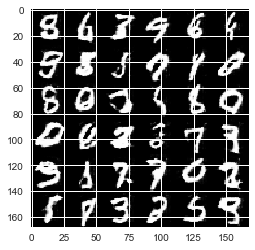

Epoch 2/2; d_loss: 1.0310; g_loss: 1.7854
Epoch 2/2; d_loss: 0.3698; g_loss: 3.1667
Epoch 2/2; d_loss: 0.6595; g_loss: 3.0315
Epoch 2/2; d_loss: 0.6293; g_loss: 1.3435
Epoch 2/2; d_loss: 0.3510; g_loss: 2.2584
Epoch 2/2; d_loss: 0.3764; g_loss: 3.2663
Epoch 2/2; d_loss: 1.5755; g_loss: 0.3802
Epoch 2/2; d_loss: 1.4538; g_loss: 0.3767
Epoch 2/2; d_loss: 0.4408; g_loss: 1.5986
Epoch 2/2; d_loss: 0.5241; g_loss: 1.2051
Epoch 2/2; d_loss: 0.4590; g_loss: 1.3801
Epoch 2/2; d_loss: 1.0765; g_loss: 0.7101
Epoch 2/2; d_loss: 0.4214; g_loss: 1.6413
Epoch 2/2; d_loss: 0.4184; g_loss: 1.5706
Epoch 2/2; d_loss: 0.3354; g_loss: 1.7741
Epoch 2/2; d_loss: 0.7429; g_loss: 1.0332
Epoch 2/2; d_loss: 0.5593; g_loss: 1.1704
Epoch 2/2; d_loss: 0.7347; g_loss: 0.9057
Epoch 2/2; d_loss: 0.3367; g_loss: 1.6602
Epoch 2/2; d_loss: 0.2608; g_loss: 2.1355


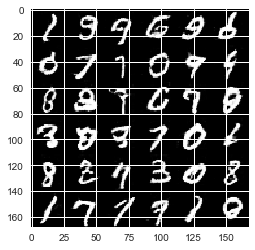

Epoch 2/2; d_loss: 0.5559; g_loss: 1.2138
Epoch 2/2; d_loss: 0.2437; g_loss: 3.4948
Epoch 2/2; d_loss: 0.4007; g_loss: 3.3945
Epoch 2/2; d_loss: 0.4471; g_loss: 1.2067
Epoch 2/2; d_loss: 0.1459; g_loss: 2.7271
Epoch 2/2; d_loss: 0.2893; g_loss: 2.0271
Epoch 2/2; d_loss: 0.5845; g_loss: 1.2480
Epoch 2/2; d_loss: 0.8512; g_loss: 0.9375
Epoch 2/2; d_loss: 0.6731; g_loss: 1.0657
Epoch 2/2; d_loss: 0.3711; g_loss: 1.6793


In [29]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3

# Reset the default graph to start with a clean slate
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.